In [13]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error , r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.svm import SVR
import numpy as np


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 492)

<b> 1. Feature Engineering </b>

In [14]:
# Load the dataset
df_data = pd.read_csv("df_merged_final.csv" , dtype={'fips': str})

#define descriptive variables
descriptive_variables = ['population', 'household income', '% insufficient sleep', 'physically unhealthy days',
                        'mentally unhealthy days', '% obese', 'food environment index',
                        '% physically inactive', 'teen birth rate', '# medicare enrollees',
                        '# some college', '% unemployed', 'income ratio',
                         '% single-parent households', '# violent crimes']

#Group above variables on the state level
df_model = df_data.groupby(['state' ])[descriptive_variables].mean().reset_index()


# Split the data into features (X) and target (y)
X = df_model[[  'population', 'household income', '% insufficient sleep', 'physically unhealthy days', '% obese', 'food environment index',
                        '% physically inactive', 'teen birth rate', '# medicare enrollees',
                        '# some college', '% unemployed', 'income ratio',
                         '% single-parent households', '# violent crimes' ]]


y = df_model['mentally unhealthy days']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



<b> 2. Create a pipeline for MLR , Random Forest , Decision Tree , Gradient Boosting  </b>

In [15]:
# Step 2: Define the pipeline

pipeline_mlr = Pipeline([
    ('scaler', StandardScaler()),  
    ('regressor', LinearRegression())  
])


pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),  # Optional: Scale the features
    ('regressor', RandomForestRegressor())  # Random Forest model
])


pipeline_dt = Pipeline([
    ('scaler', StandardScaler()),  # Optional: Scale the features
    ('regressor', DecisionTreeRegressor())  # Decision Tree model
])

pipeline_gb = Pipeline([
    ('scaler', StandardScaler()),  # Optional: Scale the features
    ('regressor', GradientBoostingRegressor())  # Gradient Boosting model
])

pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),  # Optional: Scale the features
    ('regressor', SVR())  # Gradient Boosting model
])



# Step 3: Train and evaluate each model
models = [ ('Multiple Linear Regression' , pipeline_mlr ) ,  ('Random Forest', pipeline_rf), ('Decision Tree', pipeline_dt), ('Gradient Boosting', pipeline_gb) 
           , ('Support Vector Machine', pipeline_svm)]

for model_name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{model_name} MSE: {mse}")
    r_squared = r2_score(y_test, y_pred)
    print(f"{model_name} 'R-squared: {r_squared}")

Multiple Linear Regression MSE: 0.023072905193795488
Multiple Linear Regression 'R-squared: 0.8463294906582077
Random Forest MSE: 0.03501666908728709
Random Forest 'R-squared: 0.7667814551787173
Decision Tree MSE: 0.135568425692339
Decision Tree 'R-squared: 0.09708513722802437
Gradient Boosting MSE: 0.052625247427763616
Gradient Boosting 'R-squared: 0.6495045375284196
Support Vector Machine MSE: 0.02618248602819969
Support Vector Machine 'R-squared: 0.8256190137308865


Based on above results the best model is MLR, since a lower MSE indicates better predictive accuracy and a higher R-squared shows that the model fits better to the data.

<b> 3. Feature importance according to Multiple Linear Regression </b>

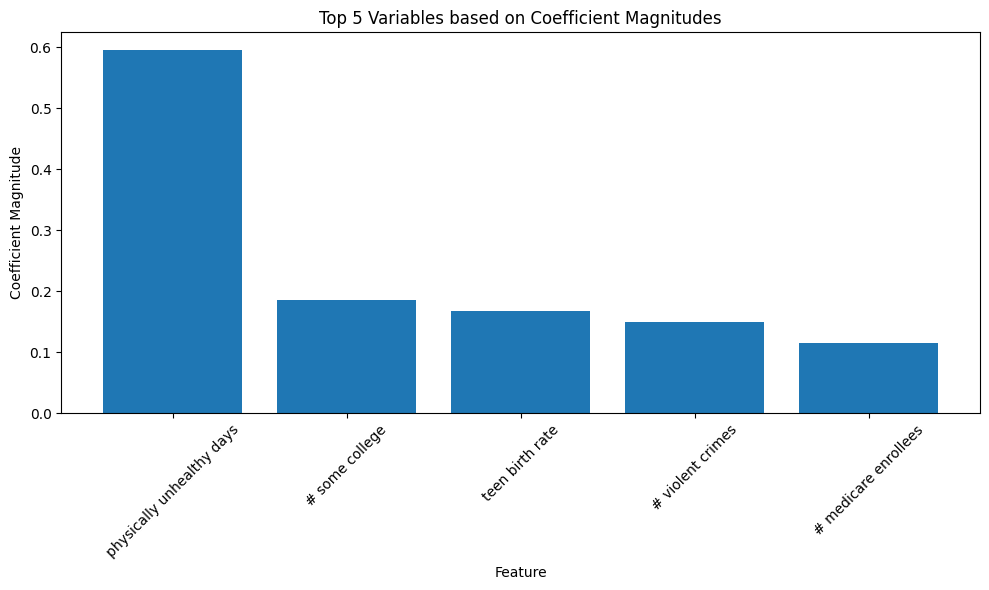

In [16]:
# Get the Linear Regression model from the pipeline
lr = pipeline_mlr.steps[-1][1]

# Get the absolute coefficient magnitudes
coefficient_magnitudes = np.abs(lr.coef_)

# Get the feature names
feature_names = list(X.columns)

# Sort the coefficients and feature names in descending order
sorted_indices = np.argsort(coefficient_magnitudes)[::-1]
sorted_magnitudes = coefficient_magnitudes[sorted_indices]
sorted_feature_names = np.array(feature_names)[sorted_indices]

# Set the number of top features to display
top_k = 5

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(top_k), sorted_magnitudes[:top_k])
plt.xticks(range(top_k), sorted_feature_names[:top_k], rotation=45)
plt.xlabel('Feature')
plt.ylabel('Coefficient Magnitude')
plt.title('Top {} Variables based on Coefficient Magnitudes'.format(top_k))
plt.tight_layout()
plt.show()

In [17]:
print("Coefficients:", lr.coef_)

Coefficients: [-0.00420013 -0.01024148  0.05024049  0.59492155  0.03217563  0.01909004
 -0.05341855 -0.16834946  0.11569446 -0.18594178 -0.07805624  0.02898615
  0.03151797  0.14977707]


In [18]:
print("Intercept:", lr.intercept_)

Intercept: 3.7533070769410677


<b> 4. Feature importance according to Random Forest Regressor </b>



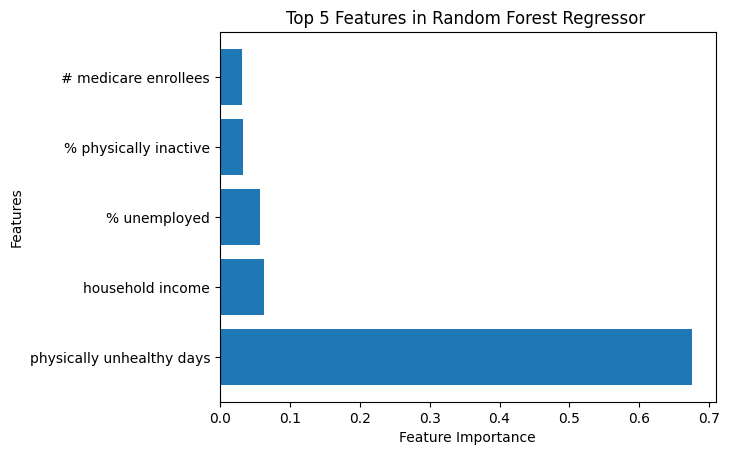

In [19]:

importances =  pipeline_rf.named_steps['regressor'].feature_importances_


top_features_indices = np.argsort(importances)[::-1][:5]  
top_features = X.columns[top_features_indices]  


plt.barh(top_features, importances[top_features_indices])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 5 Features in Random Forest Regressor ')
plt.show()


<b> 5. Feature importance according to Decision Tree Regressor </b>



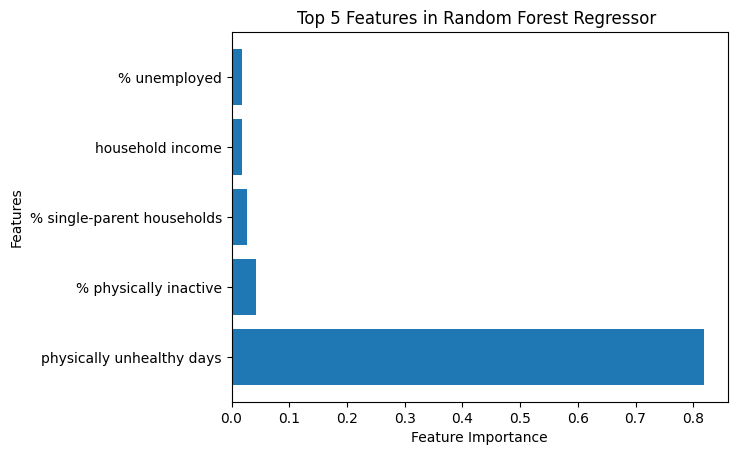

In [20]:

importances =  pipeline_gb.named_steps['regressor'].feature_importances_


top_features_indices = np.argsort(importances)[::-1][:5]  
top_features = X.columns[top_features_indices]  


plt.barh(top_features, importances[top_features_indices])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 5 Features in Random Forest Regressor ')
plt.show()

<b> 6. Feature importance according to SVM Regressor </b>

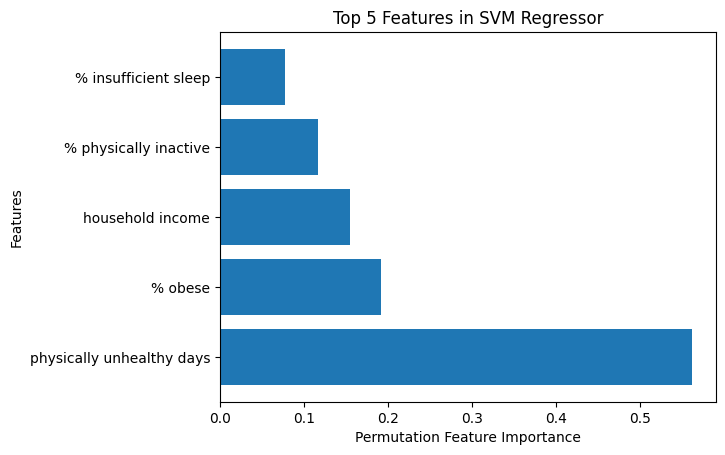

In [22]:
results = permutation_importance(pipeline_svm, X_test, y_test, n_repeats=10, random_state=42)
importances = results.importances_mean


top_features_indices = np.argsort(importances)[::-1][:5] 
top_features = X.columns[top_features_indices]  


plt.barh(top_features, importances[top_features_indices])
plt.xlabel('Permutation Feature Importance')
plt.ylabel('Features')
plt.title('Top 5 Features in SVM Regressor')
plt.show()